## Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tweepy
import requests

#### Importing archive File

In [2]:
dogs_df = pd.read_csv('twitter-archive-enhanced.csv')
dogs_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
dogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
## Checking that all tweet_ids are unique, no duplicate tweets

assert dogs_df.tweet_id.nunique() == dogs_df.shape[0]

#### Wrangling tweet image prediction image_predictions.tsv file from Udacity URL

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

with open('image_predictions.tsv', 'wb') as file:
    file.write(r.content)

In [6]:
predict_df = pd.read_csv('image_predictions.tsv', sep='\t')
predict_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Wrangling twitter retweets and likes using twiter API

In [7]:
consumer_key = '*************************'
consumer_secret = '**************************************************'

access_token = '**************************************************'
access_secret = '*********************************************'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify  = True)

In [8]:
from pprint import pprint
import json
import os
import time

def dump_tweet_json(tweet_id, file):
    """
    query the tweet json file specified by twitter id 'tweet_id'
    using twitter API tweepy, parse the json object and write it to the
    file 'file'
    
    Warning! file is assumed open in writing mode
    """
    tweet_status = api.get_status(tweet_id, tweet_mode='extended')
    json.dump(tweet_status._json, file)
    

In [9]:
deleted_tweets_ids = []
rate_limit_exceeded_tweets  = []

with open('tweet_json.txt', 'w') as file:
    
    ## First Path of Querying tweets
    ## collecting deleted tweets ids and rate_limit_exceeded_tweets
    file.write('[\n')
    for tweet_id in dogs_df.tweet_id:
        try:
            
            dump_tweet_json(tweet_id, file)
            file.write(',\n')
        
        except tweepy.error.RateLimitError:
            rate_limit_exceeded_tweets.append(tweet_id)
        
        except Exception as e:
            deleted_tweets_ids.append(tweet_id)
            print(e,' ', tweet_id)
    
    ## Second Path of Querying tweets
    ## Making sure to collect rate_limit_exceeded_tweets if any 
    
    while rate_limit_exceeded_tweets:
        try:
            tweet_id = rate_limit_exceeded_tweets[0]
            dump_tweet_json(tweet_id, file)
            file.write(',\n')
            rate_limit_exceeded_tweets.pop(0)
            
        except tweepy.error.RateLimitError:
            time.sleep(60)
            
        except tweepy.error.TweepError as tr:
            if tr.message[0]['code'] == 144:
                rate_limit_exceeded_tweets.pop(0)
            else:
                print('Twitter Error: ', twitter_err)
        
        except Exception as e:
            print(e)
            
    file.seek(file.tell() - 3, os.SEEK_SET)
    file.write('\n]')

[{'code': 144, 'message': 'No status found with that ID.'}]   888202515573088257
[{'code': 144, 'message': 'No status found with that ID.'}]   873697596434513921
[{'code': 144, 'message': 'No status found with that ID.'}]   872668790621863937
[{'code': 144, 'message': 'No status found with that ID.'}]   872261713294495745
[{'code': 144, 'message': 'No status found with that ID.'}]   869988702071779329
[{'code': 144, 'message': 'No status found with that ID.'}]   866816280283807744
[{'code': 144, 'message': 'No status found with that ID.'}]   861769973181624320
[{'code': 144, 'message': 'No status found with that ID.'}]   856602993587888130
[{'code': 144, 'message': 'No status found with that ID.'}]   845459076796616705
[{'code': 144, 'message': 'No status found with that ID.'}]   844704788403113984
[{'code': 144, 'message': 'No status found with that ID.'}]   842892208864923648
[{'code': 144, 'message': 'No status found with that ID.'}]   837012587749474308
[{'code': 144, 'message': 'N

Rate limit reached. Sleeping for: 309


[{'code': 144, 'message': 'No status found with that ID.'}]   754011816964026368
[{'code': 144, 'message': 'No status found with that ID.'}]   680055455951884288


Rate limit reached. Sleeping for: 320


In [7]:
deleted_tweets_ids = [888202515573088257, 873697596434513921,   872668790621863937,   872261713294495745,   869988702071779329,  
     866816280283807744,   861769973181624320,  856602993587888130,   845459076796616705,  844704788403113984,
     842892208864923648, 837012587749474308, 827228250799742977, 812747805718642688, 802247111496568832, 775096608509886464, 
     770743923962707968, 754011816964026368, 680055455951884288]

In [8]:
## Checking whether all deleted tweets are the same character length 

len_del = len(str(deleted_tweets_ids[5]))
for del_tweet in deleted_tweets_ids:
    assert len(str(del_tweet)) == len_del

In [9]:
## Reading needed information from tweet_json to a dataframe
## needed info.: retweet_count, favorite_count

df = pd.read_json('tweet_json.txt')
df.sample(1)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
958,NaN,NaN,2016-07-04 18:00:41,"[0, 119]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 750023357219962880, 'id_str'...",2820,False,Meet Jax &amp; Jil. Jil is yelling the pledge ...,NaN,...,NaN,NaN,NaN,NaN,835,False,NaN,"<a href=""https://about.twitter.com/products/tw...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [10]:
## Checking completeness of wrangled parsed data and given data 
## After parsing the dataframe obs should be smaller than the given original data obs
## by just the deleted tweets

assert dogs_df.shape[0] == len(deleted_tweets_ids) + df.shape[0]

In [11]:
## Interested tweets additional info 

tweets_add_df = df[['id', 'retweet_count' , 'favorite_count']].copy()

tweets_add_df.head(3)

,id,retweet_count,favorite_count
0,892420643555336193,8193,37554
1,892177421306343426,6060,32278
2,891815181378084864,4008,24320


<hr>

## Assessing and Defining Issues in the Data

In [13]:
dogs_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [14]:
tweets_add_df.head()

,id,retweet_count,favorite_count
0,892420643555336193,8193,37554
1,892177421306343426,6060,32278
2,891815181378084864,4008,24320
3,891689557279858688,8347,40905
4,891327558926688256,9040,39097


In [15]:
predict_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Assessing dogs_df

> In this section, I will assess the data. In every step, I may find an issue and will document it in markdown cells, 
at the end of the section, all issues will be summarized and classified.

In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [17]:
dogs_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [18]:
dogs_df.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


In [19]:
dogs_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
517,810896069567610880,NaN,NaN,2016-12-19 17:14:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Hunter. He just found out he needs braces. Requesting an orthodogtist stat. 11/10 you're fine Hunter, everything's fine https://t.co/zW1o0W4AYV",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/810896069567610880/photo/1,https://twitter.com/dog_rates/status/810896069567610880/photo/1,https://twitter.com/dog_rates/status/810896069567610880/photo/1",11,10,Hunter,None,None,None,None
2254,667782464991965184,NaN,NaN,2015-11-20 19:12:01 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Super rare dog. Endangered (?). Thinks it's funny. Mocks everything I say. Colorful af. Has wings (dope). 9/10 https://t.co/BY8nQAMz0x,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667782464991965184/photo/1,9,10,None,None,None,None,None
308,835574547218894849,NaN,NaN,2017-02-25 19:37:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Eli. He works backstage at Bone Jovi concerts. Heavy duty earmuffs for puptection. H*ckin safe boy. 11/10 https://t.co/cVQEnUQd8q,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/835574547218894849/photo/1,https://twitter.com/dog_rates/status/835574547218894849/photo/1",11,10,Eli,None,None,None,None
1038,744334592493166593,NaN,NaN,2016-06-19 01:02:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Blanket. She has overthrown her human. Demands walks like this every hour on the hour. 11/10 so damn fluffy https://t.co/hrJugNHs2Z,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744334592493166593/photo/1,11,10,Blanket,None,None,None,None
104,872261713294495745,NaN,NaN,2017-06-07 01:19:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Harry. His ears are activated one at a time. Incredibly rare to witness in person. Very special moment here. 13/10 blessed as h*ck https://t.co/ejHvGDfWoa,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/872261713294495745/photo/1,https://twitter.com/dog_rates/status/872261713294495745/photo/1",13,10,Harry,None,None,None,None


In [20]:
dogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

From visual assessment and info() function:
* the source column contains an html link tag that contians three types of information in one column, the source of the tweet, link of the source, 'rel' attribute.
* The doggo, pupper and puppo are all possible dog stage, so it's better  of to represent them by one column e.g dog_stage column and the stage_column should be categorized.
* Column doggo, pupper, and puppo sometimes are all Nones while a dog should be really in one of the three stages or sometimes big doggo is considered woofer, but here in the system, it seems dogs are categorized between only pupper, doggo and puppo and from further investigation visual assessment, it seems that the category of the dog is extracted from the text, so when the tweet text doesn't contain any of these words or use different words or abbreviations like 'pup', the values are none.
* Not all ratings numerators are higher than 10, some ratings actually below 10, from visual assessment, and seeing the dates, it seems all lower than 10 rating_numerators in this small sample are posted in 2015, more programmatic assessment needed here.
* The (in_reply_to_status_id, in_reply_to_user_id), (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)	seems to contain many Nones, as we see from the info function, just 78 non-nulls for in_reply and 181 for retweets and that might not come as a surprise since most tweets are originally posted by the page, and such official rating pages may not retweet often, rather a personal twitter may contain many retweets.
* The doggo, floofer, pupper, puppo doesn't contain any null entries from the info() function although we seem many Nones from the visual assessment and could be that string 'None' is inserted in them not object None.
* expanded_urls contains 59 null objects that means there are 59 tweets with no urls of photos or any url included in the text, this data could be gathered from the json file, if exists.
* There is a 'None' names in the tail and 'a' names, too. Checking the text, it seems names are extracted from statements in the form 'This is name', 'Here is name', if anything came in place of name, it's would be the name, and if the pattern doesn't exist, it will be None. A better text pattern may be used, but from this sample head, tail, sample, Sometimes names aren't really stated, somtimes breed, type or origin is stated, so we should furhter investigate name column.
* 'tweet_id' is integer, 'in_reply_to_status_id', 'retweeted_status_user_id', 'retweeted_status_id', 'retweeted_status_user_id' are floats. Timestamp columns are string objects not datetime.

Next I will check for values of every interesting column to make sure case of 'None' strings doesn't happen to other columns

In [21]:
def value_counts_per_column(df, columns):
    """
    Takes a dataframe and a set of columns in the dataframe 
    and prints out the value_counts of each column
    """
    for column in columns:
        print(df[column].value_counts())
        print('\n\n', '==' * 20, '\n\n')
        

In [22]:
value_counts_per_column(dogs_df, ['name', 'doggo', 'floofer', 'pupper', 'puppo', 'source'])

None         745
a            55 
Charlie      12 
Lucy         11 
Cooper       11 
Oliver       11 
Lola         10 
Tucker       10 
Penny        10 
Bo           9  
Winston      9  
the          8  
Sadie        8  
an           7  
Toby         7  
Bailey       7  
Daisy        7  
Buddy        7  
Scout        6  
Bella        6  
Dave         6  
Milo         6  
Leo          6  
Jax          6  
Koda         6  
Oscar        6  
Jack         6  
Rusty        6  
Stanley      6  
Alfie        5  
            ..  
Charleson    1  
Kallie       1  
Mookie       1  
Jackie       1  
Acro         1  
Chloe        1  
Derby        1  
Sephie       1  
Rolf         1  
Deacon       1  
Ronduh       1  
Sparky       1  
Kane         1  
Geno         1  
Lolo         1  
Mojo         1  
Billl        1  
Brooks       1  
Grey         1  
Heinrich     1  
Willem       1  
Lacy         1  
Baron        1  
Ralf         1  
Zooey        1  
Rhino        1  
Chubbs       1  
Tebow        1

**Observations per column(s):**
* 'name': There are many Nones and other unreasonable names like 'a', 'an', 'old', 'the'
* 'doggo', 'floofer', 'pupper', 'puppo': Values are either None or their column name, 'None' are dominant in those columns. 
* 'source': is either from Twitter for iPhone app, Vine, the Web or TweetDeck, we can see that the rel attribute takes always 'nofollow' value, so actually its existence when tidying up the column may be irrelevant, more space for no benefit, we make make a note that all links are 'nofollow' for browsers. Hence, I may argue that the html attr 'rel' is not important in our investigation or representation of the data-set.

In [23]:
## Further investigating name column

pd.set_option('display.max_rows', 500)

dogs_df['name'].value_counts()[dogs_df['name'].value_counts() > 3]

None        745
a           55 
Charlie     12 
Lucy        11 
Cooper      11 
Oliver      11 
Lola        10 
Tucker      10 
Penny       10 
Bo          9  
Winston     9  
the         8  
Sadie       8  
an          7  
Toby        7  
Bailey      7  
Daisy       7  
Buddy       7  
Scout       6  
Bella       6  
Dave        6  
Milo        6  
Leo         6  
Jax         6  
Koda        6  
Oscar       6  
Jack        6  
Rusty       6  
Stanley     6  
Alfie       5  
Phil        5  
George      5  
Louis       5  
very        5  
Sammy       5  
Finn        5  
Chester     5  
Bentley     5  
Sunny       5  
Larry       5  
Gus         5  
Oakley      5  
Riley       4  
Maximus     4  
Gary        4  
Sophie      4  
Luna        4  
Maddie      4  
Ruby        4  
Loki        4  
Beau        4  
Sampson     4  
Boomer      4  
one         4  
Derek       4  
Gerald      4  
Bear        4  
Clarence    4  
Maggie      4  
Hank        4  
Clark       4  
Scooter     4  
Winnie  

**Investigating name column furhter we notice those issues:**
1. very high count of 'None' (745)
2. Articles like 'a', 'an', 'the' adverbs like 'just', 'very', 'quite', adj like 'old' and others like  'one'.
3. Some Strange names like Chip Scooter Moose Bentley Shadow, but names by nature aren't justified, so I might dig further to those specific names, but most likely they won't considered quality issues.

The articles, adverbs and others like 'one' are all begin with lower case letters, that might help cleaning those data instead of getting list of all possible articles, adverbs and pronouns to check their existence in the names column

<hr>

In [24]:
def any_None_empty_object(df):
    """
    checks there is any 'None' or empty '' string objects values in string 
    columns and prints out the column name if any
    """
    for column in list(df):
        if df[column].dtype == np.object:
            if any(df[column].str.lower() == 'none'):
                print('%-20s'%column + "'none' strings exists")
            elif any(df[column].str.strip() == ''):
                print('%-20s'%column + 'Empty strings exist')

In [25]:
any_None_empty_object(dogs_df)

name                'none' strings exists
doggo               'none' strings exists
floofer             'none' strings exists
pupper              'none' strings exists
puppo               'none' strings exists


It seems there is no empty string objects for any string column and srings containing 'none' strings are name, doggo, pupper, puppo which we have assessed before.

<hr>

In [26]:
pd.set_option('display.max_rows', 10)

In [27]:
## Additional assessment for remaining text columns

value_counts_per_column(dogs_df, ['timestamp', 'text', 'expanded_urls', 'retweeted_status_timestamp'])

2016-12-05 17:16:37 +0000    1
2016-01-25 17:35:00 +0000    1
2015-12-03 01:16:17 +0000    1
2017-01-13 15:08:56 +0000    1
2017-01-18 20:16:54 +0000    1
                            ..
2015-11-27 20:30:30 +0000    1
2016-01-29 15:36:45 +0000    1
2016-02-14 19:35:46 +0000    1
2015-12-26 04:41:15 +0000    1
2016-01-06 18:14:31 +0000    1
Name: timestamp, Length: 2356, dtype: int64




This is Vixen. He really likes bananas. Steals them when he thinks nobody's watching. 13/10 opportunistic af https://t.co/a0CkS5ExFR            1
RT @dog_rates: This is Bo and Ty. Bo eats paper and Ty felt left out. 11/10 for both https://t.co/1acHQS8rvK                                    1
What a dog to start the day with. Very calm. Likes to chill by pond. Corkscrews sticking out of head. Obedient. 7/10 https://t.co/0nIxPTDWAZ    1
This pupper just wants a belly rub. This pupper has nothing to do w the tree being sideways now. 10/10 good pupper https://t.co/AyJ7Ohk71f      1
Say hello to Peaches. She's

**Observations:**
* The 'text' columns contains two pieces of information both the text and the t.co url link wrappers. So this is a tidyness issue. Moreover, from visual assessment and checking url, t.co links usually refer to the same page as the expaned_url, but this may should be confirmed
* Timestamp objects seems to be unique and all follow same format, but the milliseconds field is probably superfluous since all of them seems to be '+0000'. Furthermore, milliseconds aren't necessary in the investigation.
* Texts also tend to be unique as there is no text with value_count more than 1
* Expaned urls have some urls with value count more than one while we know every tweet has unique tweet_id. 
<br>In addition, For some entries, expanded urls have the same url repeated e.g. "https://twitter.com/dog_rates/status/782305867769217024/photo/1,
https://twitter.com/dog_rates/status/782305867769217024/photo/1,
https://twitter.com/dog_rates/status/782305867769217024/photo/1" <br>In addition, the urls seems to be the same, but this needs to be checked further to figure out why there are multiple links, and why the links are the same and whether the links are the same for all expaneded_urls containing more than one url. Based on those questoins, this can be a quality issue, a tidiness issue or both to be considered in the cleaning.

<hr>

In [28]:
## Checking uniqueness of tweet_id and that there is no None values
assert dogs_df['tweet_id'].nunique() == dogs_df.shape[0]

In [29]:
dogs_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


**Observations:**
* Checking (min, 25%, 50%, 75%, max), every tweet id (tweet_id, in_reply_to_status_id, retweeted_status_id) tend to be 18 digits, hence a string representation here is meaningful as mean, std doens't really mean anything here.
* On the other hand, user ids (in_reply_to_user_id, retweeted_status_user_id) doesn't all have 18 digits, some have 8 or 6 digits, up to 18 digits, according to the article [Interpreting Twitter id](https://www.adweek.com/digital/twitter-user-id/) twitter user ids gave an ordering of when a user account was created, but thinking of the 18 digit user ids, it seems the incrementing or incrementing fashion like user id system has been replaced by fixed 18 digits systems, that's just a guess, to make sure we should investigate user ids and their account launch dates. In addition, this guess is based on the fact that there is supposedly about 330 million twitter user today and there is about 7.5 billion people in the world as whole, 18 digits is much much higher number, meaning even if every person on Earth is registered on twitter, every one shall have about a billion twitter accounts so that the user_id has an ordering which is untrue.
* Rating numerators have untrue or outlier values like 1776, 0 biasing the mean and std. (quality issue)
* Rating denomenators have untrue or outlier values like 0, 170 while all denomenators should be supposedly 10. (quality issue)

> **Summarizing Data issues in dogs_df:**
* **Tidyness Issues: **
       1. Converting source column HTML to its constituent parts url, and app source, 'rel' will be discarded since it's alwasy 'no-follow'.
       2. Converting pupper, puppo, doggo value columns to be values in one column stage_column.
* **Quality Issues: **
       1. 'name' column: Clearing 'None' names and inappropriate false names like 'a', 'an' and 'the'.
       2. Changing 'floofer' column to boolean.

# Cleaning dogs_df Dataframe

In [30]:
dogs_clean = dogs_df.copy()

### Deleted Tweets

I will drop deleted tweets since I cannot assess their authenticity

In [31]:
deleted_tweets_ids = np.asarray(deleted_tweets_ids).astype(np.int64)
del_tweets_indices = dogs_clean[dogs_clean['tweet_id'].isin(deleted_tweets_ids)].index

print(dogs_clean.loc[del_tweets_indices].shape[0], len(deleted_tweets_ids))

19 19


In [32]:
## Dropping deleted tweets


dogs_clean.drop(del_tweets_indices, inplace=True)

In [33]:
## testing 

try:
    dogs_clean.loc[dol_tweets_indices]
except:
    print('Deleted tweets removed')

Deleted tweets removed


### Converting ids to strings 

First, I will convert tweeets ids to string for easier visual assessment and checking for ids and because int and float ids values doesn't convey any numerical ordering for ids.

In [34]:
## Converting tweet_id to string
dogs_clean.tweet_id = dogs_clean.tweet_id.astype(str)

When converting float ids to string, I will first need to convert them to integers, then to str, the problem is with Nan when converting from float to int, so first I will first nans with -1, then after conversion they will be returend to Nan again.

In [35]:
# Converting float ids to string
for column in list(dogs_clean):
    if column[-3:] == '_id' and any(pd.isnull(dogs_clean[column])):
        dogs_clean[column].fillna(-1, inplace = True)
        dogs_clean[column]  = dogs_clean[column].astype(np.int64).astype(str)
        dogs_clean.loc[dogs_clean[column] == '-1', column] = None

In [36]:
## testing 

dogs_clean[[col for col in list(dogs_clean) if col[-3:] == '_id']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2355
Data columns (total 5 columns):
tweet_id                    2337 non-null object
in_reply_to_status_id       78 non-null object
in_reply_to_user_id         78 non-null object
retweeted_status_id         166 non-null object
retweeted_status_user_id    166 non-null object
dtypes: object(5)
memory usage: 109.5+ KB


### Convering date column from strings to datetime objects

In [37]:
dogs_clean.timestamp.sample(2)

77      2017-06-22 03:54:17 +0000
1797    2015-12-16 23:29:14 +0000
Name: timestamp, dtype: object

In [38]:
dogs_clean.retweeted_status_timestamp.dropna().sample(2)

309    2017-02-24 23:04:14 +0000
800    2016-08-15 16:22:20 +0000
Name: retweeted_status_timestamp, dtype: object

In [39]:
dogs_clean.timestamp = pd.to_datetime(dogs_clean.timestamp, format = '%Y-%m-%d %H:%M:%S')
dogs_clean.retweeted_status_timestamp = pd.to_datetime(dogs_clean.retweeted_status_timestamp, format = '%Y-%m-%d %H:%M:%S')
dogs_clean.timestamp.head(2)

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
Name: timestamp, dtype: datetime64[ns]

In [40]:
## testing

dogs_clean[['timestamp', 'retweeted_status_timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2355
Data columns (total 2 columns):
timestamp                     2337 non-null datetime64[ns]
retweeted_status_timestamp    166 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 54.8 KB


### Source column

In [41]:
dogs_clean.source.head()

0    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
2    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
3    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
4    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
Name: source, dtype: object

In [42]:
dogs_clean[['source_app', 'source_url']] = dogs_clean.source.str.extract('<a href="(.*)" rel="nofollow">(.*)</a>')[[1,0]]

In [43]:
dogs_clean[['source', 'source_app', 'source_url']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2355
Data columns (total 3 columns):
source        2337 non-null object
source_app    2337 non-null object
source_url    2337 non-null object
dtypes: object(3)
memory usage: 73.0+ KB


In [44]:
dogs_clean[['source', 'source_app', 'source_url']].sample(5)

,source,source_app,source_url
639,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Twitter for iPhone,http://twitter.com/download/iphone
1039,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Twitter for iPhone,http://twitter.com/download/iphone
495,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Twitter for iPhone,http://twitter.com/download/iphone
2051,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Twitter for iPhone,http://twitter.com/download/iphone
135,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Twitter for iPhone,http://twitter.com/download/iphone


In [45]:
dogs_clean.drop(columns = ['source'], inplace=True)

In [46]:
list(dogs_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'source_app',
 'source_url']

### Text, Url

Since the urls are [t.co](https://help.twitter.com/en/using-twitter/how-to-tweet-a-link) shortened twitter url, the regex here is specific to capture those specific urls

In [47]:
dogs_clean['shortened_urls'] = dogs_clean.text.str.extract('(https?://t.co/[a-zA-Z0-9]{10})')[0]

In [48]:
dogs_clean.text.head()

0    This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU                                                     
1    This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
2    This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB                 
3    This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ                                                           
4    This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f
Name: text, dtype: object

In [49]:
## Removing urls from text and visually testing 
dogs_clean.text = dogs_clean.text.str.replace('(https?://t.co/[a-zA-Z0-9]{10})', '')
dogs_clean.text.head()

0    This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10                                                      
1    This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 
2    This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10                  
3    This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us                                                            
4    This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek 
Name: text, dtype: object

In [50]:
dogs_clean[['shortened_urls', 'expanded_urls', 'text']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2355
Data columns (total 3 columns):
shortened_urls    2203 non-null object
expanded_urls     2278 non-null object
text              2337 non-null object
dtypes: object(3)
memory usage: 73.0+ KB


Now we have separated text and urls, it seems some text doesn't contain shortenered_urls, hence I will iterate over those

In [51]:
##  Removing the urls from text
none_shortened_urls = dogs_clean[pd.isnull(dogs_clean.shortened_urls)]
none_shortened_urls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 30 to 2298
Data columns (total 19 columns):
tweet_id                      134 non-null object
in_reply_to_status_id         55 non-null object
in_reply_to_user_id           55 non-null object
timestamp                     134 non-null datetime64[ns]
text                          134 non-null object
retweeted_status_id           76 non-null object
retweeted_status_user_id      76 non-null object
retweeted_status_timestamp    76 non-null datetime64[ns]
expanded_urls                 75 non-null object
rating_numerator              134 non-null int64
rating_denominator            134 non-null int64
name                          134 non-null object
doggo                         134 non-null object
floofer                       134 non-null object
pupper                        134 non-null object
puppo                         134 non-null object
source_app                    134 non-null object
source_url                    134 n

In [52]:
none_shortened_urls.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
30,886267009285017600,886266357075128320,2281181600,2017-07-15 16:51:35,@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,None,None,NaT,NaN,12,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN


In [53]:
none_shortened_urls.tail(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
2298,667070482143944705,667065535570550784,4196983835,2015-11-18 20:02:51,After much debate this dog is being upgraded to 10/10. I repeat 10/10,None,None,NaT,NaN,10,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN


In [54]:
none_shortened_urls.sample(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
431,820837357901512704,None,None,2017-01-16 03:37:31,RT @dog_rates: This is Finn. He's wondering if you come here often. Fr*ckin flirtatious af. 12/10 would give number to https://t.co/ii5eNX5…,819227688460238848,4196983835,2017-01-11 17:01:16,https://twitter.com/dog_rates/status/819227688460238848/photo/1,12,10,Finn,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN


We can see that some of those null shortened_urls tweets have null expanded_urls, too. In this case, all of the processed tweets through head, tail and sample tend to be a reply tweet as the in_reply_to_status_id, in_reply_to_user_id columns aren't empty.<br>
On the other hand, some of those null shortened_urls tweets do have expaned_urls values and checking through head, tail, and sample, those tweets tend to be retweets.<br>
**That said, some data issues has been found here:**
* @user mentions appended at the begining of those in reply texts .e.g @NonWhiteHat @MayhewMayhem (left after in-response cleaning)
* RT @user: at the beginning of each retweet text appened to retweet texts .e.g RT @dog_rates:, checking the twitter [retweet doc intro](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json.html), it seems this appending action is deliberately done by the twitter api itself. (left to retweets cleaning)
* Truncated urls at the end in retweet texts (.e.g  'https://…', 'https:/…', 'https://t.co/…')
* Expanded urls do have different urls sometimes, for example https://www.gofundme.com/3yd6y1c, https://twitter.com/dog_rates/status/878281511006478336/photo/1 at the end of the head and the first link is a link included by the WeRateDogs tweet for funding, so we may expect that expanded tweets include also links included in the tweet text
* Finally, we may retain in replies url by the following link format http://twitter.com/{twitter-user-id}/status/{tweet-status-id}, for example https://twitter.com/dog_rates/status/886267009285017600, so no need for expanded_urls if they just represent tweet url (more on this in the expanded_urls cleaning section).

**Fixing truncated urls**

In [55]:
truncated_urls_indices = dogs_clean.text.str.extract('(https?[^\s]+)').dropna().index
dogs_clean.loc[truncated_urls_indices, 'text'].head()

68    RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…  
73    RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…
74    RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…  
91    RT @dog_rates: This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly https://t.c…  
97    RT @dog_rates: This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps:/…
Name: text, dtype: object

In [56]:
dogs_clean.loc[truncated_urls_indices, 'text'] = dogs_clean.loc[truncated_urls_indices, 'text'].str.replace(
    '(https?[^\s]*)|([^\s]*t.co[^\s]*)|(\\n)*', ''
)

In [57]:
## visual testing 
dogs_clean.loc[truncated_urls_indices, 'text'].head()

68    RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved 
73    RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below 
74    RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance       
91    RT @dog_rates: This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly    
97    RT @dog_rates: This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below 
Name: text, dtype: object

<hr>

### Cleaning name column

In [58]:
def cleaning_None_objects(df, columns):
    """
    Converting string 'None' object to None (null objects)
    """
    if isinstance(columns, list):
        for column in columns:
            df.loc[df[column] == 'None', column] = None
    elif isinstance(columns, str):
         df.loc[df[columns].str.lower() == 'none', columns] = None

In [59]:
dogs_clean.query('name == "None"').shape[0]

738

**Issues to clean:**
1. very high count of None (738)
2. Articles like 'a', 'an', 'the' adverbs like 'just', 'very', 'quite', adj like 'old' and others like  'one'.

The articles, adverbs and others like 'one' are all begin with lower case letters, so I will first capture those names beginning with lower case letter, assessing all are non-names,then nullifying or correcting them if possible

** 'None' strings issues **

In [60]:
dogs_clean[['tweet_id', 'name']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2355
Data columns (total 2 columns):
tweet_id    2337 non-null object
name        2337 non-null object
dtypes: object(2)
memory usage: 134.8+ KB


In [61]:
## Converting 'None' to null objects 
cleaning_None_objects(dogs_clean, 'name')

In [62]:
## testing 
dogs_clean[['tweet_id', 'name']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2355
Data columns (total 2 columns):
tweet_id    2337 non-null object
name        1599 non-null object
dtypes: object(2)
memory usage: 134.8+ KB


In [63]:
## number of non nulls + number of "None" strings shall equal to number of rows
assert 1599 + 738 == 2337

** Lower case names issues ** 

In [64]:
pd.set_option('display.max_rows', 80)
dogs_clean[dogs_clean.name.str.contains('^[a-z0-9].*', na=False)].name.value_counts()

a               55
the             8 
an              7 
very            5 
just            4 
one             4 
quite           3 
getting         2 
actually        2 
not             2 
mad             2 
light           1 
life            1 
my              1 
incredibly      1 
such            1 
infuriating     1 
by              1 
space           1 
officially      1 
his             1 
unacceptable    1 
old             1 
this            1 
all             1 
Name: name, dtype: int64

In [65]:
fault_names_indices = dogs_clean.name.str.contains('^[a-z0-9].*', na=False)

In [66]:
dogs_clean[fault_names_indices][['text', 'name', 'expanded_urls']].sample(5)

,text,name,expanded_urls
2287,This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10,a,https://twitter.com/dog_rates/status/667177989038297088/photo/1
1853,This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof,a,https://twitter.com/dog_rates/status/675706639471788032/photo/1
1049,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately,a,https://twitter.com/dog_rates/status/743222593470234624/photo/1
1941,This is a heavily opinionated dog. Loves walls. Nobody knows how the hair works. Always ready for a kiss. 4/10,a,https://twitter.com/dog_rates/status/673715861853720576/photo/1
2161,This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots,a,https://twitter.com/dog_rates/status/669564461267722241/photo/1


Sometimes name is not mentioned at all, but other times name is mentioned like the following patterns
named Kohl, Her name is Zoey, 13/10 for both owner and Forrest.
In that case I will retain only those and set the others to null

In [67]:
name_fix1 = dogs_clean[fault_names_indices].text.str.extract('named?\s*(is|are)?\s*([A-Z][a-z]*)')[1]

In [68]:
# 13/10 for both owner and Forrest
name_fix2 = dogs_clean[fault_names_indices].text.str.extract('[0-9]+/[0-9]+\s*for\s*(.*)([A-Z][a-z]*)')[1]

In [69]:
## Setting Nones to '' for easily concatenating the two string object series
name_fix2[name_fix2.isnull()] = ''
name_fix1[name_fix1.isnull()] = ''

In [70]:
pd.concat([name_fix1, name_fix2], axis = 1).shape[0]

108

In [71]:
## testing for collision between name fixes columns before concatenation, there is none

assert np.logical_and(name_fix1 != '', name_fix2 != '').any() == False

In [72]:
## Concatenating name fixes, if there is collision, I will notice in visual assessment

name_fix = name_fix1 + name_fix2

In [73]:
## nullifying empty strings 

name_fix.loc[name_fix == ''] = None

In [74]:
name_fix.dropna()

369     Grace    
649     Forrest  
852     Zoey     
1853    Wylie    
1955    Kip      
2034    Jacob    
2066    Rufus    
2116    Spork    
2125    Cherokee 
2128    Hemry    
2146    Alphred  
2161    Alfredo  
2191    Leroi    
2204    Berta    
2218    Chuk     
2235    Alfonso  
2249    Cheryl   
2255    Jessiga  
2264    Klint    
2273    Kohl     
2287    Daryl    
2304    Pepe     
2311    Octaviath
2314    Johm     
Name: 1, dtype: object

In [75]:
## Asserting all indices are the same before fixing column names 
assert all(name_fix.index == fault_names_indices[fault_names_indices].index)

In [76]:
dogs_clean.loc[fault_names_indices, 'name'] = name_fix

In [77]:
dogs_clean.loc[fault_names_indices].name

22      None     
56      None     
169     None     
193     None     
335     None     
369     Grace    
542     None     
649     Forrest  
682     None     
759     None     
773     None     
801     None     
819     None     
822     None     
852     Zoey     
924     None     
988     None     
992     None     
993     None     
1002    None     
1004    None     
1017    None     
1025    None     
1031    None     
1040    None     
1049    None     
1063    None     
1071    None     
1095    None     
1097    None     
1120    None     
1121    None     
1138    None     
1193    None     
1206    None     
1207    None     
1259    None     
1340    None     
1351    None     
1361    None     
        ...      
2030    None     
2034    Jacob    
2037    None     
2066    Rufus    
2116    Spork    
2125    Cherokee 
2128    Hemry    
2146    Alphred  
2153    None     
2161    Alfredo  
2191    Leroi    
2198    None     
2204    Berta    
2211    None     
2212    No

In [78]:
## Iterating 

dogs_clean.text.str.extract('named?\s*(is|are)?\s*([A-Z][a-z]*)').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2355
Data columns (total 2 columns):
0    9 non-null object
1    33 non-null object
dtypes: object(2)
memory usage: 134.8+ KB


Testing the regex on the entire name column yields 33 non-null names, 13 more than applied to the incorrect column names<br>
Thats why I will try to fix those more 13 ones 

In [79]:
named_faults = dogs_clean.text.str.extract('named?\s*(is|are)?\s*([A-Z][a-z]*)')[1]

In [80]:
named_faults[np.logical_not(named_faults.isnull())]

35      Howard    
168     Zoey      
603     Tickles   
843     Charley   
852     Zoey      
1678    Thea      
1734    Sabertooth
1853    Wylie     
1955    Kip       
2034    Jacob     
2066    Rufus     
2116    Spork     
2125    Cherokee  
2128    Hemry     
2146    Alphred   
2161    Alfredo   
2166    Zeus      
2191    Leroi     
2204    Berta     
2218    Chuk      
2227    Guss      
2235    Alfonso   
2249    Cheryl    
2255    Jessiga   
2264    Klint     
2267    Big       
2269    Tickles   
2273    Kohl      
2287    Daryl     
2304    Pepe      
2311    Octaviath 
2313    Rocky     
2314    Johm      
Name: 1, dtype: object

In [81]:
dogs_clean.loc[named_faults[np.logical_not(named_faults.isnull())].index, 'name']

35      None     
168     None     
603     None     
843     None     
852     Zoey     
1678    None     
1734    None     
1853    Wylie    
1955    Kip      
2034    Jacob    
2066    Rufus    
2116    Spork    
2125    Cherokee 
2128    Hemry    
2146    Alphred  
2161    Alfredo  
2166    None     
2191    Leroi    
2204    Berta    
2218    Chuk     
2227    None     
2235    Alfonso  
2249    Cheryl   
2255    Jessiga  
2264    Klint    
2267    None     
2269    None     
2273    Kohl     
2287    Daryl    
2304    Pepe     
2311    Octaviath
2313    Lugan    
2314    Johm     
Name: name, dtype: object

In [82]:
## Correcting only those having None as their names

indices = dogs_clean.loc[named_faults[np.logical_not(named_faults.isnull())].index, 'name'].isnull()

In [83]:
dogs_clean.loc[indices.index[indices], 'name'] = named_faults.loc[indices.index[indices]]
dogs_clean.loc[indices.index[indices], 'name']

35      Howard    
168     Zoey      
603     Tickles   
843     Charley   
1678    Thea      
1734    Sabertooth
2166    Zeus      
2227    Guss      
2267    Big       
2269    Tickles   
Name: name, dtype: object

<hr>

### Retweets

First, I will drop retweets of of the same page previous tweets if those original tweets exist in the table<br>
WeRateDogs user_id: 4196983835

In [84]:
pd.set_option('display.max_rows', 6)

In [85]:
we_rate_dogs_retweets = dogs_clean[
    dogs_clean.retweeted_status_user_id == '4196983835'
].retweeted_status_id.isin(dogs_clean.tweet_id)

In [86]:
we_rate_dogs_retweets

36      True
68      True
73      True
        ... 
1012    True
1023    True
1043    True
Name: retweeted_status_id, Length: 143, dtype: bool

In [87]:
dogs_clean.loc[we_rate_dogs_retweets.index].head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
36,885311592912609280,None,None,2017-07-13 01:35:06,RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well,830583320585068544,4196983835,2017-02-12 01:04:29,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/SATN4If5H5
68,879130579576475649,None,None,2017-06-26 00:13:58,RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved,878057613040115712,4196983835,2017-06-23 01:10:23,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN


In [88]:
## Selecting retweets of WeRateDogs user that have existent original tweets and dropping them 

dogs_clean.drop(we_rate_dogs_retweets[we_rate_dogs_retweets].index, inplace=True)

In [89]:
dogs_clean[['tweet_id', 'retweeted_status_user_id']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2231 entries, 0 to 2355
Data columns (total 2 columns):
tweet_id                    2231 non-null object
retweeted_status_user_id    60 non-null object
dtypes: object(2)
memory usage: 52.3+ KB


number of retweets dropped from 181 to 60. Checking other retweets

In [90]:
dogs_clean.loc[dogs_clean.retweeted_status_id.dropna().index].head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
32,886054160059072513,None,None,2017-07-15 02:45:48,RT @Athletics: 12/10 #BATP,886053734421102592,19607400,2017-07-15 02:44:07,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/WxwJmvjfxo
78,877611172832227328,None,None,2017-06-21 19:36:23,RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10,876850772322988032,512804507,2017-06-19 17:14:49,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1",14,10,None,None,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/dJx4Gzc50G


In [91]:
dogs_clean.loc[dogs_clean.retweeted_status_id.dropna().index].sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
558,803321560782307329,None,None,2016-11-28 19:35:59,RT @dog_rates: This is Philbert. His toilet broke and he doesn't know what to do. Trying not to panic. 11/10 furustrated af,767754930266464256,4196983835,2016-08-22 16:06:54,https://twitter.com/dog_rates/status/767754930266464257/photo/1,11,10,Philbert,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
272,840761248237133825,None,None,2017-03-12 03:07:56,RT @dog_rates: Say hello to Maddie and Gunner. They are considerably pupset about bath time. Both 12/10 but Gunner needs your help,840632337062862848,4196983835,2017-03-11 18:35:42,"https://www.gofundme.com/3hgsuu0,https://twitter.com/dog_rates/status/840632337062862849/photo/1",12,10,Maddie,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN


In [92]:
dogs_clean[['tweet_id', 'expanded_urls']].head()

,tweet_id,expanded_urls
0,892420643555336193,https://twitter.com/dog_rates/status/892420643555336193/photo/1
1,892177421306343426,https://twitter.com/dog_rates/status/892177421306343426/photo/1
2,891815181378084864,https://twitter.com/dog_rates/status/891815181378084864/photo/1
3,891689557279858688,https://twitter.com/dog_rates/status/891689557279858688/photo/1
4,891327558926688256,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1"


There is an issue I detected here in expanded_urls and retweeted status id, but I won't clean it as I don't know its exact cause, subsequently, don't know whether it's really an issue:
* Look at the expanded_urls and tweet_id in the head above, you'll find tweet ids in the expanded_urls as-is and that's expected, but at look at the sample above you'll find the expanded_urls contain the retweedted_status_id incremented by one .e.g retweeted_status_id = 725842289046749184, and expanded_url = https://twitter.com/dog_rates/status/<font color="red">725842289046749185</font>/photo/1 and this repeates in other retweets, too. Another example is 887473957103951872 for retweeted_status_id and 887473957103951883 in expanded_url. So there  probably some type of counter if as in the last example the ids are almost the same but the expanded_url ends in 83, but the retweeted_status_id ends in 72.

* And some other times the status_id in the link is totally different from both retweeted_status_id and the tweet_id especially when the retweeted_user_id isn't WeRateDogs. So does those urls really belong to those tweets? 

When Checking the links using the decremented retweeted_status_id, it seems the original tweet is deleted and in other cases, I find a quoted tweet so the rest cleaning of retweets can be done using quoted_tweets, but I will clean the text from RT @user retweets additions as tweets and retweets texts are the same, quoted tweets on the other hand are different, but that's another investigation. I will refrain from processing retweets further, may save & drop them entirely at the end.

In [93]:
dogs_clean[np.logical_not(dogs_clean.retweeted_status_id.isnull())].text

32      RT @Athletics: 12/10 #BATP                                                                                                      
78      RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10                              
91      RT @dog_rates: This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly 
                                                                      ...                                                               
1242    RT @twitter: @dog_rates Awesome Tweet! 12/10. Would Retweet. #LoveTwitter                                                       
2259    RT @dogratingrating: Exceptional talent. Original humor. Cutting edge, Nova Scotian comedian. 12/10                             
2260    RT @dogratingrating: Unoriginal idea. Blatant plagiarism. Curious grammar. -5/10                                                
Name: text, Length: 60, dtype: object

In [94]:
rt_text = dogs_clean[np.logical_not(dogs_clean.retweeted_status_id.isnull())].text

In [95]:
dogs_clean.loc[rt_text.index, 'text'] = rt_text.replace('RT @[^\s]+:\s*', '', regex = True)

In [96]:
dogs_clean.loc[rt_text.index].text

32      12/10 #BATP                                                                                                      
78      @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10                               
91      This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly 
                                                              ...                                                        
1242    @dog_rates Awesome Tweet! 12/10. Would Retweet. #LoveTwitter                                                     
2259    Exceptional talent. Original humor. Cutting edge, Nova Scotian comedian. 12/10                                   
2260    Unoriginal idea. Blatant plagiarism. Curious grammar. -5/10                                                      
Name: text, Length: 60, dtype: object

> Another issue I will not clean are hashtags, mentions and links to Instagram (.e.g I.G)

<hr>

### Assessing In response tweets

In [97]:
dogs_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
0,892420643555336193,None,None,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,None,None,NaT,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/MgUWQ76dJU


In [98]:
temp = dogs_clean[np.logical_not(dogs_clean.in_reply_to_status_id.isnull())]

In [99]:
temp[temp.in_reply_to_status_id.isin(dogs_clean.tweet_id)].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
184,856526610513747968,855818117272018944,4196983835,2017-04-24 15:13:52,"THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH",None,None,NaT,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/p1hBHCmWnA
228,848213670039564288,848212111729840128,4196983835,2017-04-01 16:41:12,Jerry just apuppologized to me. He said there was no ill-intent to the slippage. I overreacted I admit. Pupgraded to an 11/10 would pet,None,None,NaT,NaN,11,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
251,844979544864018432,759099523532779520,4196983835,2017-03-23 18:29:57,"PUPDATE: I'm proud to announce that Toby is 236 days sober. Pupgraded to a 13/10. We're all very proud of you, Toby",None,None,NaT,"https://twitter.com/dog_rates/status/844979544864018432/photo/1,https://twitter.com/dog_rates/status/844979544864018432/photo/1,https://twitter.com/dog_rates/status/844979544864018432/photo/1",13,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/a5OaJeRl9B
498,813130366689148928,813127251579564032,4196983835,2016-12-25 21:12:41,I've been informed by multiple sources that this is actually a dog elf who's tired from helping Santa all night. Pupgraded to 12/10,None,None,NaT,NaN,12,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
513,811647686436880384,811627233043480576,4196983835,2016-12-21 19:01:02,PUPDATE: I've been informed that Augie was actually bringing his family these flowers when he tripped. Very good boy. Pupgraded to 11/10,None,None,NaT,NaN,11,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN


In [100]:
temp[temp.in_reply_to_status_id.isin(dogs_clean.tweet_id)].text

184     THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH                       
228     Jerry just apuppologized to me. He said there was no ill-intent to the slippage. I overreacted I admit. Pupgraded to an 11/10 would pet
251     PUPDATE: I'm proud to announce that Toby is 236 days sober. Pupgraded to a 13/10. We're all very proud of you, Toby                    
                                                                ...                                                                            
2149    After countless hours of research and hundreds of formula alterations we have concluded that Dug should be bumped to an 11/10          
2169    This is Tessa. She is also very pleased after finally meeting her biological father. 10/10                                             
2298    After much debate this dog is being upgraded to 10/10. I repeat 10/10                                                           

In [101]:
import re 
temp[temp.in_reply_to_status_id.isin(dogs_clean.tweet_id)].text.str.extract(
    'graded to\s*([^\s0-9]+)?\s*(\d+)/(\d+)', flags= re.IGNORECASE
)

,0,1,2
184,A,14,10
228,an,11,10
251,a,13,10
...,...,...,...
2149,NaN,NaN,NaN
2169,NaN,NaN,NaN
2298,NaN,10,10


Looking closely at the in_reply tweets most of them aren't real rating, they're either upgrading to the ratings and we know that the ratings in WeRateDogs aren't actually consistent ratings and others are like comments in other people posts, some are ratings, but to clean to the bottom is real time-consuming, so I'll save them ot in_reply_df and drop them and note that in the internal documents. Then I will drop the columns.

to_save

In [102]:
## Dropping in_reply rows

in_reply_df = temp.copy()
dogs_clean.drop(temp.index, inplace = True)

In [103]:
## Dropping in_reply columns

dogs_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis = 1, inplace=True)
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2153 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2153 non-null object
timestamp                     2153 non-null datetime64[ns]
text                          2153 non-null object
retweeted_status_id           60 non-null object
retweeted_status_user_id      60 non-null object
retweeted_status_timestamp    60 non-null datetime64[ns]
expanded_urls                 2149 non-null object
rating_numerator              2153 non-null int64
rating_denominator            2153 non-null int64
name                          1453 non-null object
doggo                         2153 non-null object
floofer                       2153 non-null object
pupper                        2153 non-null object
puppo                         2153 non-null object
source_app                    2153 non-null object
source_url                    2153 non-null object
shortened_urls                2123 non-null object
dtypes: datetime64

<hr>

### Fixing scores

#### Numerators

In [104]:
pd.set_option('display.max_rows', 50)

In [105]:
dogs_clean[dogs_clean.rating_numerator <= 5].rating_numerator.value_counts()

5    35
3    19
4    16
2    9 
1    5 
0    1 
Name: rating_numerator, dtype: int64

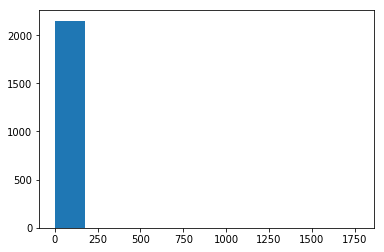

In [106]:
plt.hist(dogs_clean.rating_numerator);

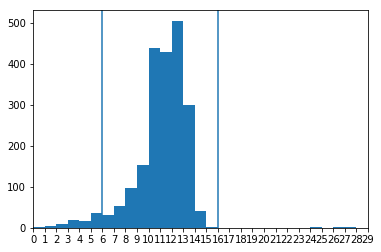

In [107]:
plt.subplot(111)
plt.hist(dogs_clean.rating_numerator, bins=range(0, 30, 1));
plt.xlim(0, 20)
plt.xticks(range(0, 30, 1))
plt.axvline(x= np.percentile(dogs_clean.rating_numerator, 5))
plt.axvline(x= 16)

In [108]:
dogs_clean.query('rating_numerator < 7').sample(1)

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
1928,674045139690631169,2015-12-08 01:57:39,Herd of wild dogs here. Not sure what they're trying to do. No real goals in life. 3/10 find your purpose puppers,None,None,NaT,https://twitter.com/dog_rates/status/674045139690631169/photo/1,3,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/t5ih0VrK02


Many of the ratings below 7 ratings aren't for dogs, some are extracted wrong because the user uses floats like 13.5/10, so it is extracted as 5/10 because an integer pattern is used in extraction, so I will first try to extract those because they're floats and then drop those below 7 ratings because most of them aren't for dogs and I will round the float ratings to integers since actually they're all good dogs and ratings system here isn't ordinal<br>
I found also a wrong numerator because the existence of two fractions in the text, but one of them is actually a rating, so I will try to extract those ratings again to account for wrong captured ratings, then I will drop ratings below 5 to account for minimum possible errors, hoping other non-dog ratings be captured by the machine learning algorithm

Since there are few ratings with very low rating like 0,1,2,3,4. I will assess the tweets by myself and drop them if needed

<center>** Zero Rating tweets **</center>

In [109]:
dogs_clean[dogs_clean.rating_numerator == 0][['tweet_id', 'expanded_urls', 'shortened_urls']]

,tweet_id,expanded_urls,shortened_urls
315,835152434251116546,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",https://t.co/YbEJPkg4Ag


The tweet don't represent real ratings, so I will drop them  

In [110]:
dogs_clean.drop(dogs_clean[dogs_clean.rating_numerator == 0].index, inplace=True);

<hr>

<center>** One Rating tweets **</center>

In [111]:
dogs_clean[dogs_clean.rating_numerator == 1][['tweet_id', 'expanded_urls', 'shortened_urls']]

,tweet_id,expanded_urls,shortened_urls
1869,675153376133427200,https://twitter.com/dog_rates/status/675153376133427200/photo/1,https://t.co/RDXCfk8hK0
2091,670783437142401025,https://twitter.com/dog_rates/status/670783437142401025/photo/1,https://t.co/jxukeh2BeO
2261,667549055577362432,https://twitter.com/dog_rates/status/667549055577362432/photo/1,https://t.co/i9iSGNn3fx
2335,666287406224695296,https://twitter.com/dog_rates/status/666287406224695296/photo/1,https://t.co/d9NcXFKwLv
2338,666104133288665088,https://twitter.com/dog_rates/status/666104133288665088/photo/1,https://t.co/Asgdc6kuLX


In [112]:
dogs_clean.loc[dogs_clean.tweet_id == '666287406224695296', 'rating_numerator'] = 9
dogs_clean.loc[dogs_clean.tweet_id == '666287406224695296', 'rating_numerator'] = 10

In [113]:
dogs_clean.drop(dogs_clean[dogs_clean.rating_numerator == 1].index, inplace=True)

<hr>

<center>** Two Rating tweets **</center>

In [114]:
dogs_clean[dogs_clean.rating_numerator == 2][['tweet_id', 'expanded_urls', 'shortened_urls']]

,tweet_id,expanded_urls,shortened_urls
1761,678675843183484930,https://twitter.com/dog_rates/status/678675843183484930/photo/1,https://t.co/a8SqCaSo2r
1764,678424312106393600,https://twitter.com/dog_rates/status/678424312106393600/photo/1,https://t.co/rtMtjSl9pz
1920,674265582246694913,https://twitter.com/dog_rates/status/674265582246694913/photo/1,https://t.co/Pu9RhfHDEQ
2079,670826280409919488,https://twitter.com/dog_rates/status/670826280409919488/photo/1,https://t.co/XOPXCSXiUT
2237,668142349051129856,https://twitter.com/dog_rates/status/668142349051129856/photo/1,https://t.co/DnhUw0aBM2
2246,667878741721415682,https://twitter.com/dog_rates/status/667878741721415682/photo/1,https://t.co/LvP1TTYSCN
2310,666786068205871104,https://twitter.com/dog_rates/status/666786068205871104/photo/1,https://t.co/EIn5kElY1S
2326,666411507551481857,https://twitter.com/dog_rates/status/666411507551481857/photo/1,https://t.co/aMCTNWO94t
2349,666051853826850816,https://twitter.com/dog_rates/status/666051853826850816/photo/1,https://t.co/v5A4vzSDdc


In [115]:
dogs_clean.drop([1761, 1920,2079, 2237, 2310, 2326, 2349], inplace = True)

In [116]:
dogs_clean[dogs_clean.rating_numerator == 2][['tweet_id', 'expanded_urls', 'shortened_urls']]

,tweet_id,expanded_urls,shortened_urls
1764,678424312106393600,https://twitter.com/dog_rates/status/678424312106393600/photo/1,https://t.co/rtMtjSl9pz
2246,667878741721415682,https://twitter.com/dog_rates/status/667878741721415682/photo/1,https://t.co/LvP1TTYSCN


the 1764 is real low ratings, don't know why, but I shouldn't ask with this crazy ratings system, the 2246 is incorrect, so I'll fix it

In [117]:
## he used 10&2 as a way of exaggeration
dogs_clean.loc[2246, 'rating_numerator'] = 10

<hr>

<center>** Three Rating tweets **</center>

In [118]:
dogs_clean[dogs_clean.rating_numerator == 3][['tweet_id', 'expanded_urls', 'shortened_urls']]

,tweet_id,expanded_urls,shortened_urls
765,777885040357281792,"https://twitter.com/dog_rates/status/777885040357281792/photo/1,https://twitter.com/dog_rates/status/777885040357281792/photo/1",https://t.co/pL7wbMRW7M
1189,718246886998687744,https://twitter.com/dog_rates/status/718246886998687744/photo/1,https://t.co/FmxOpf2Sgl
1249,711306686208872448,"https://twitter.com/dog_rates/status/711306686208872448/photo/1,https://twitter.com/dog_rates/status/711306686208872448/photo/1",https://t.co/wcwoGOkZvz
1314,706901761596989440,https://twitter.com/dog_rates/status/706901761596989440/photo/1,https://t.co/FMUxir5pYu
1406,699088579889332224,https://twitter.com/dog_rates/status/699088579889332224/photo/1,https://t.co/VfLoDZecJ7
1478,693590843962331137,https://twitter.com/dog_rates/status/693590843962331137/photo/1,https://t.co/fShNNhBWYx
1601,686003207160610816,https://twitter.com/dog_rates/status/686003207160610816/photo/1,https://t.co/NOIiRWr5Jf
1692,681302363064414209,https://twitter.com/dog_rates/status/681302363064414209/photo/1,https://t.co/YqbU9xHV3p
1836,676098748976615425,https://twitter.com/dog_rates/status/676098748976615425/photo/1,https://t.co/REyE5YKVBb
1898,674690135443775488,https://twitter.com/dog_rates/status/674690135443775488/photo/1,https://t.co/Unz1uNrOzo


In [119]:
indices = set(dogs_clean[dogs_clean.rating_numerator == 3][['tweet_id', 'expanded_urls', 'shortened_urls']].index)
indices -= set([2183, 1249])
indices = list(indices)
indices

[1314,
 1601,
 2305,
 1189,
 1478,
 1928,
 1898,
 1836,
 1938,
 2334,
 2136,
 2202,
 1947,
 1692,
 765,
 1406,
 2239]

In [120]:
dogs_clean.drop(indices, inplace = True)

In [121]:
dogs_clean.query('rating_numerator == 3').shape[0] == 2

True

<hr>

<center>** Four Rating tweets **</center>

In [122]:
dogs_clean.query('rating_numerator == 4')[['tweet_id', 'expanded_urls', 'shortened_urls']]

,tweet_id,expanded_urls,shortened_urls
883,760252756032651264,https://twitter.com/dog_rates/status/760252756032651264/photo/1,https://t.co/4gOv2Q3iKP
912,757596066325864448,https://twitter.com/dog_rates/status/757596066325864448/photo/1,https://t.co/mOmnL19Wsl
1004,747816857231626240,https://twitter.com/dog_rates/status/747816857231626240/photo/1,https://t.co/L3U0j14N5R
1165,722974582966214656,https://twitter.com/dog_rates/status/722974582966214656/photo/1,https://t.co/eV1diwds8a
1219,714631576617938945,https://twitter.com/dog_rates/status/714631576617938945/photo/1,https://t.co/3oeFfHjv0Z
1303,707420581654872064,https://twitter.com/dog_rates/status/707420581654872064/photo/1,https://t.co/xOrUyj7K30
1459,695064344191721472,https://twitter.com/dog_rates/status/695064344191721472/video/1,https://t.co/uaJmNgXR2P
1629,684567543613382656,https://twitter.com/dog_rates/status/684567543613382656/photo/1,https://t.co/b8XW69gSaU
1701,680940246314430465,https://twitter.com/dog_rates/status/680940246314430465/photo/1,https://t.co/VQXdwJfkyS
1941,673715861853720576,https://twitter.com/dog_rates/status/673715861853720576/photo/1,https://t.co/dFiaKZ9cDl


In [123]:
dogs_clean.loc[1165, 'rating_numerator'] = 13
dogs_clean.loc[1165, 'rating_denominator'] = 10

In [124]:
dogs_clean = dogs_clean.query('rating_numerator != 4')

In [125]:
dogs_clean.query('rating_numerator == 4').shape[0] == 0

True

<hr>

For those higher ratings than 4, the process is tedious to clean all the data from animals other than dogs, so I'll merge the data set with the machine learning algorithms in the second cleaning iteration and find those tweets where the algorithm say that the photo doesn't represents dogs and drop them, but I noticed some tweets were captured wrong because of fractions, so I will try to clear those first using regex

In [126]:
b_7_indices = dogs_clean[dogs_clean.rating_numerator < 7].index

In [127]:
b_7_indices

Int64Index([  45,  229,  730,  956,  993, 1078, 1125, 1241, 1249, 1363, 1388,
            1392, 1399, 1460, 1461, 1508, 1583, 1619, 1624, 1636, 1645, 1680,
            1708, 1727, 1759, 1764, 1787, 1796, 1803, 1808, 1820, 1839, 1861,
            1874, 1901, 1904, 1925, 1972, 1979, 1986, 1992, 2013, 2026, 2033,
            2040, 2044, 2063, 2071, 2092, 2100, 2109, 2119, 2134, 2139, 2153,
            2157, 2163, 2181, 2183, 2206, 2238, 2242, 2260, 2276, 2312, 2322,
            2330, 2342, 2351, 2352],
           dtype='int64')

In [128]:
## Fixing only those that may contain ratings_numerators higher than or equal to 10 in their text
dogs_clean.loc[b_7_indices].text.str.extract('(\d{2})\s*/\s*(10)').dropna()

,0,1
1508,10,10


In [129]:
dogs_clean.loc[1508][['tweet_id', 'shortened_urls']]

tweet_id          691483041324204033     
shortened_urls    https://t.co/aenk0KpoWM
Name: 1508, dtype: object

In this tweet multiple (two dogs) are rated, I'll keep the higher rating 10, they're good dogs, aren't they?

In [130]:
dogs_clean.loc[1508, 'rating_numerator'] = 10

Cleaning fractions

In [131]:
incorrect_numerators = dogs_clean.text.str.extract('(\d+\.\d+)\s*/\s*(10)').dropna()
incorrect_numerators

,0,1
45,13.5,10
695,9.75,10
763,11.27,10
1712,11.26,10


In [132]:
dogs_clean.loc[incorrect_numerators.index][['tweet_id', 'text', 'rating_numerator']]

,tweet_id,text,rating_numerator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",5
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",75
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,27
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,26


Analayzing the tweets:

I will first fix the numerator ratings for those fraction tweets, but will round up the fraction to an integer since the difference is small.

In [133]:
dogs_clean.loc[incorrect_numerators.index, 'rating_numerator'] = np.ceil(incorrect_numerators[0].astype(float)).astype(np.int64)

### Analyzing tweets with very high ratings_numerators

In [134]:
pd.set_option('display.max_rows', 30)
dogs_clean[dogs_clean.rating_numerator > 16].shape

(15, 17)

I will go through them one by one since they are only 15

In [135]:
dogs_clean.query('rating_numerator > 16')[['tweet_id', 'shortened_urls', 'text']]

,tweet_id,shortened_urls,text
433,820690176645140481,https://t.co/NIYC820tmd,The floofs have been released I repeat the floofs have been released. 84/70
516,810984652412424192,https://t.co/98tB8y7y7t,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\n
902,758467244762497024,https://t.co/HmwrdfEfUE,Why does this never happen at my front door... 165/150
979,749981277374128128,https://t.co/GRXwMxLBkh,This is Atticus. He's quite simply America af. 1776/10
1120,731156023742988288,https://t.co/yGQI3He3xv,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once
1202,716439118184652801,https://t.co/Kky1DPG4iq,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10
1228,713900603437621249,https://t.co/mpvaVxKmc1,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody
1254,710658690886586372,https://t.co/0eb7R1Om12,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80
1274,709198395643068416,https://t.co/sedre1ivTK,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once"
1351,704054845121142784,https://t.co/9dpcw6MdWa,Here is a whole flock of puppers. 60/50 I'll take the lot


In [136]:
## 2074 isn't a dog, 516 isn't a dog rating, but funding only
dogs_clean.drop([2074, 516], inplace=True)

In [137]:
## Fixing one incorrect ratings

dogs_clean.loc[1202, 'rating_numerator'] = 11
dogs_clean.loc[1202, 'rating_denominator'] = 10

The rest are multiple dogs ratings, I check their rating denomunator if it's not ten, the numerator and denomenator will be scaled to ten scale, as for those cases the photos represent more than 1 dog, so the rater tries to be realistic and gives a wholistic rating. It ain't funny for us Madd Melson 😡😡😠😠

In [138]:
temp = dogs_clean.query('rating_numerator > 16 and rating_denominator > 10')
temp.index

Int64Index([433, 902, 1120, 1228, 1254, 1274, 1351, 1433, 1635, 1779, 1843], dtype='int64')

In [139]:
dogs_clean.loc[temp.index, 'rating_numerator'] = np.ceil(temp.rating_numerator * 10/ temp.rating_denominator).astype(int)
dogs_clean.loc[temp.index, 'rating_denominator'] = 10

In [140]:
assert dogs_clean.query('rating_numerator > 16 and rating_denominator > 10').shape[0] == 0

The rating numerator of 1776, I can't fix it as it's as-is of one dog and with rating denominator of 10, crazy system Brent!

### Fixing the rest of the denominator 

In [141]:
dogs_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo', 'source_app', 'source_url',
       'shortened_urls'],
      dtype='object')

In [142]:
dogs_clean.query('rating_denominator != 10')[['rating_numerator', 'rating_denominator', 'tweet_id', 'expanded_urls', 'text']]

,rating_numerator,rating_denominator,tweet_id,expanded_urls,text
1068,9,11,740373189193256964,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP"
1662,7,11,682962037429899265,https://twitter.com/dog_rates/status/682962037429899265/photo/1,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10
2335,10,2,666287406224695296,https://twitter.com/dog_rates/status/666287406224695296/photo/1,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10


In [143]:
dogs_clean.loc[1068, ['rating_numerator', 'rating_denominator']] = [14, 10]
dogs_clean.loc[1662, ['rating_numerator', 'rating_denominator']] = [10, 10]
dogs_clean.loc[2335, ['rating_numerator', 'rating_denominator']] = [9, 10]

<hr>

### Expanded_urls

Additional remarks on expanded_urls:
* The expanded_urls are multi-valued.
* If the tweet contains multiple photos, the expanded_urls usually contain multiple links with the ending of photo/1 where the number of the photo/1 expanded url is equal to the number of photos
* The expanded_urls contain additional links that were included in the tweet like gofundme

Fix:
* First, I will assess and clean null expanded_urls
* Then, expaned_urls will be removed from dogs_clean dataframe and create another dataframe probagating the tweet_id and the individual links, then fixing the links if possible to refer to individual photos

### Fixing null expanded_urls

In [144]:
dogs_clean[dogs_clean.expanded_urls.isnull()]

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
185,856330835276025856,2017-04-24 02:15:55,@dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,856330158768218112,66699013,2017-04-24 02:13:14,NaN,14,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
375,828361771580813312,2017-02-05 21:56:51,Beebop and Doobert should start a band 12/10 would listen,None,None,NaT,NaN,12,10,None,None,None,None,None,Twitter Web Client,http://twitter.com,NaN
707,785515384317313025,2016-10-10 16:20:36,"Today, 10/10, should be National Dog Rates Day",None,None,NaT,NaN,10,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN
1445,696518437233913856,2016-02-08 02:18:30,Oh my god 10/10 for every little hot dog pupper,None,None,NaT,NaN,10,10,None,None,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,NaN


In [145]:
## Checking if the retweet_status_id 856282028240666624 of the tweet_id 856330835276025856 exist in the dataframe
dogs_clean.query('tweet_id == "856282028240666624"')[['tweet_id', 'text']]

,tweet_id,text
187,856282028240666624,"This is Cermet, Paesh, and Morple. They are absolute h*ckin superstars. Watered every day so they can grow. 14/10 for all"


* The first retweet is a response to another WeRateDogs tweet which by checking its id in the tweet link, appears to exist in our tweets. (to remove)
* The other three tweets don't contain any photos and they're actually not specific dog ratings. (to remove)

In [146]:
dogs_clean.drop(dogs_clean[dogs_clean.expanded_urls.isnull()].index, inplace = True)

In [147]:
assert dogs_clean[dogs_clean.expanded_urls.isnull()].shape[0] == 0

### Tidying expanded_urls

First I will extract the photos_urls from the tweet dataframe and then will replace 

In [148]:
tweets_urls = dogs_clean[['tweet_id', 'expanded_urls']].copy()

In [149]:
tweets_urls.reset_index(inplace=True, drop = True)
tweets_urls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103 entries, 0 to 2102
Data columns (total 2 columns):
tweet_id         2103 non-null object
expanded_urls    2103 non-null object
dtypes: object(2)
memory usage: 32.9+ KB


In [150]:
## Expanding tweet urls, and dropping the expanded_urls column 

tweets_urls['urls'] = tweets_urls.expanded_urls.str.split(',')
tweets_urls.drop('expanded_urls', axis = 1, inplace = True)
tweets_urls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103 entries, 0 to 2102
Data columns (total 2 columns):
tweet_id    2103 non-null object
urls        2103 non-null object
dtypes: object(2)
memory usage: 32.9+ KB


In [151]:
tweets_urls.sample(2)

,tweet_id,urls
605,781163403222056960,[https://twitter.com/dog_rates/status/781163403222056960/photo/1]
120,865718153858494464,[https://twitter.com/dog_rates/status/865718153858494464/photo/1]


In [152]:
def extract_photos_urls(tweet):
    """
    Extract media photos included in the tweet
    from the tweet json media extended_entities
    """
    photos = []
    if(isinstance(tweet['extended_entities'], dict)):
        for med in tweet['extended_entities']['media']:
            if med['type'] == 'photo':
                photos.append(med['media_url_https'])

            
    return {'tweet_id': tweet['id'], 'media_urls' : photos if len(photos) != 0 else None}

In [153]:
## Extracting photos for tweet ids included in the tweets_urls dataframe

media_urls_df = df[df.id.astype(str).isin(tweets_urls.tweet_id)]
media_urls_df = pd.DataFrame(list(media_urls_df.apply(extract_photos_urls, axis = 1)))
media_urls_df.head(2)

,media_urls,tweet_id
0,[https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg],892420643555336193
1,[https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg],892177421306343426


In [154]:
media_urls_df.tweet_id = media_urls_df.tweet_id.astype(str)
media_urls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103 entries, 0 to 2102
Data columns (total 2 columns):
media_urls    1872 non-null object
tweet_id      2103 non-null object
dtypes: object(2)
memory usage: 32.9+ KB


inspecting media_urls, some tweet_ids can't find media for them, there might be a better way to extract media object, but I could find and it's time consuming, so I'll note that in the internal document

In [155]:
def unify_urls(tweet):
    """
    unify urls from media_urls and tweets_urls cleaning by ignoring photo/1 links 
    in tweets_urls if corresponding photos urls exist in media_urls_df
    """
    photos_len = len(tweet.media_urls) if tweet.media_urls is not None else 0
    urls_unified = []
    index = 0
    for url in tweet.urls:
        if url[-len('photo/1'):] == 'photo/1' and index < photos_len:
            urls_unified.append(tweet.media_urls[index])
            index += 1
        else:
            urls_unified.append(url)
    return{'tweet_id': tweet['tweet_id'], 'urls': urls_unified if len(urls_unified) != 0 else None}

In [156]:
unified_urls = pd.DataFrame(
    list(tweets_urls.merge(media_urls_df, how = 'left', on = 'tweet_id').apply(unify_urls, axis = 1))
)
unified_urls.head(2)

,tweet_id,urls
0,892420643555336193,[https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg]
1,892177421306343426,[https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg]


In [157]:
unified_urls = unified_urls.merge(unified_urls.urls.apply(pd.Series), left_index = True, right_index = True)
unified_urls.head(1)

,tweet_id,urls,0,1,2,3,4,5,6,7
0,892420643555336193,[https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg],https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cleaning urls having more than 4 links if applicable

In [158]:
unified_urls.loc[unified_urls[4].dropna().index]

,tweet_id,urls,0,1,2,3,4,5,6,7
100,870656317836468226,"[https://www.gofundme.com/help-fix-codys-torn-acl, https://pbs.twimg.com/media/DBUxSSHXsAIz4Un.jpg, https://pbs.twimg.com/media/DBUxSSNXYAA9VO_.jpg, https://pbs.twimg.com/media/DBUxSSYW0AQOCOx.jpg, https://pbs.twimg.com/media/DBUxSSTXsAA-Jn1.jpg]",https://www.gofundme.com/help-fix-codys-torn-acl,https://pbs.twimg.com/media/DBUxSSHXsAIz4Un.jpg,https://pbs.twimg.com/media/DBUxSSNXYAA9VO_.jpg,https://pbs.twimg.com/media/DBUxSSYW0AQOCOx.jpg,https://pbs.twimg.com/media/DBUxSSTXsAA-Jn1.jpg,NaN,NaN,NaN
129,863062471531167744,"[https://www.gofundme.com/helpquinny, https://pbs.twimg.com/media/C_o2vKFV0AAcq9j.jpg, https://pbs.twimg.com/media/C_o2vKCUwAAgtOp.jpg, https://pbs.twimg.com/media/C_o2vKCUMAAewwp.jpg, https://pbs.twimg.com/media/C_o2vKEUAAA_pfA.jpg]",https://www.gofundme.com/helpquinny,https://pbs.twimg.com/media/C_o2vKFV0AAcq9j.jpg,https://pbs.twimg.com/media/C_o2vKCUwAAgtOp.jpg,https://pbs.twimg.com/media/C_o2vKCUMAAewwp.jpg,https://pbs.twimg.com/media/C_o2vKEUAAA_pfA.jpg,NaN,NaN,NaN
153,857393404942143489,"[https://www.gofundme.com/meeko-needs-heart-surgery, https://pbs.twimg.com/media/C-YSwA9XcAAxF_0.jpg, https://pbs.twimg.com/media/C-YSwA9XUAECvVK.jpg, https://pbs.twimg.com/media/C-YSwA_XgAEOr25.jpg, https://pbs.twimg.com/media/C-YSwA9XUAArZf1.jpg]",https://www.gofundme.com/meeko-needs-heart-surgery,https://pbs.twimg.com/media/C-YSwA9XcAAxF_0.jpg,https://pbs.twimg.com/media/C-YSwA9XUAECvVK.jpg,https://pbs.twimg.com/media/C-YSwA_XgAEOr25.jpg,https://pbs.twimg.com/media/C-YSwA9XUAArZf1.jpg,NaN,NaN,NaN
290,832032802820481025,"[https://www.petfinder.com/petdetail/34918210, https://pbs.twimg.com/media/C4v5a4UWcAIRygc.jpg, https://pbs.twimg.com/media/C4v5a5EWMAA0_fH.jpg, https://pbs.twimg.com/media/C4v5a4oWAAIUQbv.jpg, https://pbs.twimg.com/media/C4v5a4YWQAAUjDP.jpg]",https://www.petfinder.com/petdetail/34918210,https://pbs.twimg.com/media/C4v5a4UWcAIRygc.jpg,https://pbs.twimg.com/media/C4v5a5EWMAA0_fH.jpg,https://pbs.twimg.com/media/C4v5a4oWAAIUQbv.jpg,https://pbs.twimg.com/media/C4v5a4YWQAAUjDP.jpg,NaN,NaN,NaN
294,831650051525054464,"[http://www.gofundme.com/bluethewhitehusky, https://pbs.twimg.com/media/C4qdThOWAAI3WX3.jpg, https://pbs.twimg.com/media/C4qdThMWcAI9jUg.jpg, https://pbs.twimg.com/media/C4qdThPWEAIk9qP.jpg, https://pbs.twimg.com/media/C4qdThOWAAEW5B9.jpg]",http://www.gofundme.com/bluethewhitehusky,https://pbs.twimg.com/media/C4qdThOWAAI3WX3.jpg,https://pbs.twimg.com/media/C4qdThMWcAI9jUg.jpg,https://pbs.twimg.com/media/C4qdThPWEAIk9qP.jpg,https://pbs.twimg.com/media/C4qdThOWAAEW5B9.jpg,NaN,NaN,NaN
303,830097400375152640,"[https://www.gofundme.com/sick-baby-samson, https://pbs.twimg.com/media/C4UZLYyXUAAaSyA.jpg, https://pbs.twimg.com/media/C4UZLYxXAAEB05M.jpg, https://pbs.twimg.com/media/C4UZLZLWYAEiqQW.jpg, https://pbs.twimg.com/media/C4UZLZLWYAA0dcs.jpg]",https://www.gofundme.com/sick-baby-samson,https://pbs.twimg.com/media/C4UZLYyXUAAaSyA.jpg,https://pbs.twimg.com/media/C4UZLYxXAAEB05M.jpg,https://pbs.twimg.com/media/C4UZLZLWYAEiqQW.jpg,https://pbs.twimg.com/media/C4UZLZLWYAA0dcs.jpg,NaN,NaN,NaN
332,826204788643753985,"[http://us.blastingnews.com/news/2017/01/kentucky-teen-helps-lost-yellow-labrador-and-gets-a-huge-surprise-001431969.html?sbdht=_pM1QUzk3wsenGU1giO7UnJ5NGGiKRW9AD5xs2MkaDpYY13JxbtKE4w2_, https://pbs.twimg.com/media/C3dEzahWAAA3QFj.jpg, https://pbs.twimg.com/media/C3dEza1WcAAhlNU.jpg, https://pbs.twimg.com/media/C3dEzcoWMAEx9AU.jpg, https://pbs.twimg.com/media/C3dEzc6XAAAehSt.jpg]",http://us.blastingnews.com/news/2017/01/kentucky-teen-helps-lost-yellow-labrador-and-gets-a-huge-surprise-001431969.html?sbdht=_pM1QUzk3wsenGU1giO7UnJ5NGGiKRW9AD5xs2MkaDpYY13JxbtKE4w2_,https://pbs.twimg.com/media/C3dEzahWAAA3QFj.jpg,https://pbs.twimg.com/media/C3dEza1WcAAhlNU.jpg,https://pbs.twimg.com/media/C3dEzcoWMAEx9AU.jpg,https://pbs.twimg.com/media/C3dEzc6XAAAehSt.jpg,NaN,NaN,NaN
351,822647212903690241,"[https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg, https:

Checking the links, cleaning is needed only for 351, 375 rows

In [159]:
unified_urls.loc[351, list(range(3, 8))] = None
unified_urls.loc[351]

tweet_id    822647212903690241                                                                                                                                                                                                                                                                                                                                    
urls        [https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg, https://pbs.twimg.com/media/C2oRbOxWQAIpnBA.jpg, https://pbs.twimg.com/media/C2oRbOwWIAANYrq.jpg, https://twitter.com/dog_rates/status/822489057087389700/photo/1, https://twitter.com/dog_rates/status/822489057087389700/photo/1, https://twitter.com/dog_rates/status/822489057087389700/photo/1]
0           https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg                                                                                                                                                                                                                                       

In [160]:
unified_urls.loc[375, list(range(4, 8))] = None
unified_urls.loc[375]

tweet_id    819015331746349057                                                                                                                                                                                                                                                                                                                                                                                                                                                      
urls        [https://pbs.twimg.com/media/C12x-IXVQAA08TD.jpg, https://pbs.twimg.com/media/C12x-IgUsAAulM4.jpg, https://pbs.twimg.com/media/C12x-JRUAAIgwdf.jpg, https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg, https://twitter.com/dog_rates/status/819006400881917954/photo/1, https://twitter.com/dog_rates/status/819006400881917954/photo/1, https://twitter.com/dog_rates/status/819006400881917954/photo/1, https://twitter.com/dog_rates/status/819006400881917954/photo/1]
0           https://pbs.twimg.com/media/C12x-IXVQAA08TD.jpg   

Now I will drop columns 5-7, and rearrange the urls dataframe and saving the unified_urls dataframe

In [161]:
unified_urls.drop(list(range(5, 8)) + ['urls'], axis = 1, inplace=True)
unified_urls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103 entries, 0 to 2102
Data columns (total 6 columns):
tweet_id    2103 non-null object
0           2103 non-null object
1           543 non-null object
2           240 non-null object
3           127 non-null object
4           8 non-null object
dtypes: object(6)
memory usage: 98.7+ KB


In [162]:
## Rearranging and Dropping the unnecessary variable column

unified_urls = pd.melt(unified_urls, id_vars=['tweet_id'] , value_vars= range(5), value_name='url')
unified_urls.drop('variable', axis = 1, inplace = True)
unified_urls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10515 entries, 0 to 10514
Data columns (total 2 columns):
tweet_id    10515 non-null object
url         3021 non-null object
dtypes: object(2)
memory usage: 164.4+ KB


url has 3021 non_null object which is the true expectations since there is 2103 + 543 + 240 + 127 + 8 == 3021, <br>
where 2103, 543, 240, 127, 8 represents 0, 1, 2, 3, 4 columns non-null objets

In [163]:
## Dropping null urls 

unified_urls.drop(unified_urls[unified_urls.url.isnull()].index, inplace = True)
unified_urls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3021 entries, 0 to 9503
Data columns (total 2 columns):
tweet_id    3021 non-null object
url         3021 non-null object
dtypes: object(2)
memory usage: 70.8+ KB


Dropping remaining urls ending in /photo/1 as they link to the tweet not the photos <br>
and linking to tweet url is easy knowing the tweet id, so no need for them 

In [164]:
unified_urls.drop(unified_urls[unified_urls.url.str.strip().str.endswith('/photo/1')].index, inplace = True)
unified_urls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2942 entries, 0 to 9503
Data columns (total 2 columns):
tweet_id    2942 non-null object
url         2942 non-null object
dtypes: object(2)
memory usage: 69.0+ KB


# Saving Dataframe

## to_save

unified_urls

<hr>

## fixing puppo, pupper, doggo columns

Before converting puppo, pupper, doggo to a stage column, we should clean the 'None' string objects

In [165]:
cleaning_None_objects(dogs_clean, ['doggo', 'pupper', 'puppo', 'floofer'])
dogs_clean[['doggo', 'puppo', 'pupper']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2103 entries, 0 to 2355
Data columns (total 3 columns):
doggo     86 non-null object
puppo     24 non-null object
pupper    234 non-null object
dtypes: object(3)
memory usage: 65.7+ KB


Also, it's logical that a dog cannot be both pupper and doggo for example because they're different ages, but nothing is guaranteed from messy data, so I will check for this

In [166]:
## Checking for crossed values before melting

# this cell checks if there dogs classified as either (doggo, pupper), 
# (doggo, puppo), (pupper, puppo) or (doggo, pupper, puppo)

dogs_stages = ['doggo', 'puppo', 'pupper']

for i in range(len(dogs_stages)):
    j = i + 1
    for j in range(i + 1, len(dogs_stages)):
        print('(%s, %s)' %(dogs_stages[i], dogs_stages[j]),
             dogs_clean.query('%s == "%s" and %s == "%s"'%(dogs_stages[i], dogs_stages[i], dogs_stages[j], dogs_stages[j])).shape[0]
             )

## Checking for three columns
print('(%s, %s, %s)' %('doggo', 'puppo', 'pupper'),
             dogs_clean.query('doggo == "doggo" and puppo == "puppo" and pupper == "pupper"').shape[0]
     )

(doggo, puppo) 1
(doggo, pupper) 9
(puppo, pupper) 0
(doggo, puppo, pupper) 0


It seems that there are 1 dog classifed as both doggo and puppo and 9 classifed as both doggo and pupper, so I will check the urls of those dogs

In [167]:
## doggo and puppo 

dogs_clean.query('doggo == "doggo" and puppo == "puppo"')

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
191,855851453814013952,2017-04-22 18:31:02,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for,None,None,NaT,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/cMhq16isel


It seems that this dog is actually puppo, so I will change this doggo entry to None

In [168]:
dogs_clean.loc[191, 'doggo'] = None

In [169]:
## Testing
assert dogs_clean.query('doggo == "doggo" and puppo == "puppo"').shape[0] == 0

In [170]:
pd.set_option('display.max_rows', 30)
dogs_clean.query('doggo == "doggo" and pupper == "pupper"')

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,shortened_urls
460,817777686764523521,2017-01-07 16:59:28,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo)",None,None,NaT,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/m7isZrOBX7
531,808106460588765185,2016-12-12 00:29:28,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time,None,None,NaT,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/ANBpEYHaho
575,801115127852503040,2016-11-22 17:28:25,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine,None,None,NaT,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/55Dqe0SJNj
705,785639753186217984,2016-10-11 00:34:48,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously,None,None,NaT,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/f2wmLZTPHd
733,781308096455073793,2016-09-29 01:42:20,"Pupper butt 1, Doggo 0. Both 12/10",None,None,NaT,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None,Vine - Make a Scene,http://vine.co,https://t.co/WQvcPEpH2u
889,759793422261743616,2016-07-31 16:50:42,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time",None,None,NaT,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",12,10,Maggie,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/MYwR4DQKll
956,751583847268179968,2016-07-09 01:08:47,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho,None,None,NaT,https://twitter.com/dog_rates/status/751583847268179968/photo/1,5,10,None,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/u2c9c7qSg8
1063,741067306818797568,2016-06-10 00:39:48,This is just downright precious af. 12/10 for both pupper and doggo,None,None,NaT,https://twitter.com/dog_rates/status/741067306818797568/photo/1,12,10,None,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/o5J479bZUC
1113,733109485275860992,2016-05-19 01:38:16,"Like father (doggo), like son (pupper). Both 12/10",None,None,NaT,https://twitter.com/dog_rates/status/733109485275860992/photo/1,12,10,None,doggo,None,pupper,None,Twitter for iPhone,http://twitter.com/download/iphone,https://t.co/pG2inLaOda


Checking the urls, one dog is actually only pupper, but others contains a photo of a doggo with his pupper and one isn't actually a dog, so I will refrain from converting the columns to one column dog_stage as some photos and ratings contain more than one dog_stage and if I converted to dog_stage column I will have then multi-valued column. <br>
Therefore, I will fix first the incorrect ones, drop the non-dog and then convert each column to a boolean like string ('True', 'False') to indicate that the some photos contains more than one dog, also will convert floofer column in the same way. I considered converting the columns to booleans, but since there is no way to probagate nulls in a boolean column in pandas, it will be semantically misleading as many rows will have False in all dog stages (pupper, puppo, doggo), but the dog has to be in one of the stages. I will document this in the internal document along why I didn't convert to dog_stage column.

In [171]:
## Nulling incorrect values

dogs_clean.loc[[460, 575], 'doggo'] = None
dogs_clean.loc[956, 'pupper'] = None

In [172]:
## Droping the no-dog tweeet

dogs_clean.drop(705, inplace=True)

In [173]:
dogs_clean[['doggo', 'puppo', 'pupper', 'floofer']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102 entries, 0 to 2355
Data columns (total 4 columns):
doggo      82 non-null object
puppo      24 non-null object
pupper     232 non-null object
floofer    10 non-null object
dtypes: object(4)
memory usage: 82.1+ KB


In [174]:
dogs_clean.pupper = dogs_clean.pupper.str.replace('pupper', 'True')
dogs_clean.puppo = dogs_clean.puppo.str.replace('puppo', 'True')
dogs_clean.doggo = dogs_clean.doggo.str.replace('doggo', 'True')
dogs_clean.floofer = dogs_clean.floofer.str.replace('floofer', 'True')

In [175]:
## If a row is categorized as one or more dog stage, 
## None entries in the same row are falsified

cols = ['pupper', 'puppo', 'doggo']

for ind in dogs_clean.index:
    for col in cols:
        if(dogs_clean.loc[ind, col] == 'True'):
            for col in cols:
                if dogs_clean.loc[ind, col] == None:
                    dogs_clean.loc[ind, col] = 'False'
            break

In [176]:
## testing 

for col in cols:
    print(dogs_clean[col].value_counts())

True     232
False    101
Name: pupper, dtype: int64
False    309
True     24 
Name: puppo, dtype: int64
False    251
True     82 
Name: doggo, dtype: int64


In [177]:
## testing

dogs_clean.loc[dogs_clean.pupper.dropna().index, ['doggo', 'puppo', 'pupper']].head()

,doggo,puppo,pupper
9,True,False,False
12,False,True,False
14,False,True,False
29,False,False,True
43,True,False,False


In [178]:
dogs_clean[['doggo', 'puppo', 'pupper', 'floofer']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102 entries, 0 to 2355
Data columns (total 4 columns):
doggo      333 non-null object
puppo      333 non-null object
pupper     333 non-null object
floofer    10 non-null object
dtypes: object(4)
memory usage: 162.1+ KB


There was 10 interleavings between dog stages, but after cleaning 5 of them( 1 : {puppo, pupper}, 4 {pupper, doggo}), <br>5 remains. Hence, checking the validity of falsifying entries knowing the number of non-nulls and interleavings according to the following

       333 == 232 (non-Nones puper) + 24 (non-null puppo) + 82(non-null doggo) - 5
       333 == 338 -5
       333 == 333
       
       
Hence, falsying entries operation is valid

In [179]:
## Extra-test check if a column exist contain all Falses
assert dogs_clean.query('doggo == "False" and pupper == "False" and puppo == "False"').shape[0] == 0

<hr>

# Second Iteration

Since expanded urls aren't needed any more, it is removed from dogs_clean and also the shortened_urls as I don't think they will be needed in the anlysis

In [180]:
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2102 non-null object
timestamp                     2102 non-null datetime64[ns]
text                          2102 non-null object
retweeted_status_id           59 non-null object
retweeted_status_user_id      59 non-null object
retweeted_status_timestamp    59 non-null datetime64[ns]
expanded_urls                 2102 non-null object
rating_numerator              2102 non-null int64
rating_denominator            2102 non-null int64
name                          1436 non-null object
doggo                         333 non-null object
floofer                       10 non-null object
pupper                        333 non-null object
puppo                         333 non-null object
source_app                    2102 non-null object
source_url                    2102 non-null object
shortened_urls                2076 non-null object
dtypes: datetime64[ns](

In [181]:
dogs_clean.drop(['shortened_urls', 'expanded_urls'], axis = 1, inplace=True)
list(dogs_clean)

['tweet_id',
 'timestamp',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'source_app',
 'source_url']

About the rest of the retweets, As I doubtful of their cleaness, but also sure that they're not retweets of<br>
WeRateDogs previous posts conatained in the dogs_clean dataframe, so I'll save them in separate dataframe for future reference and will clean the entires, then drop the column

In [182]:
### Checking if any of the retweeted_status_ids are in the original tweets
any(dogs_clean.retweeted_status_id.dropna().isin(dogs_clean.tweet_id))

False

In [183]:
retweets_df = dogs_clean.loc[dogs_clean.retweeted_status_id.dropna().index].copy()
retweets_df.head(3)

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url
32,886054160059072513,2017-07-15 02:45:48,12/10 #BATP,886053734421102592,19607400,2017-07-15 02:44:07,12,10,None,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone
78,877611172832227328,2017-06-21 19:36:23,@dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10,876850772322988032,512804507,2017-06-19 17:14:49,14,10,None,False,None,True,False,Twitter for iPhone,http://twitter.com/download/iphone
91,874434818259525634,2017-06-13 01:14:41,This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly,866334964761202688,4196983835,2017-05-21 16:48:45,12,10,Coco,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone


In [184]:
dogs_clean.drop(retweets_df.index, inplace = True)
dogs_clean[['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2043 entries, 0 to 2355
Data columns (total 3 columns):
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 63.8+ KB


In [185]:
dogs_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'],
                axis = 1, inplace = True)
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2043 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2043 non-null object
timestamp             2043 non-null datetime64[ns]
text                  2043 non-null object
rating_numerator      2043 non-null int64
rating_denominator    2043 non-null int64
name                  1401 non-null object
doggo                 324 non-null object
floofer               10 non-null object
pupper                324 non-null object
puppo                 324 non-null object
source_app            2043 non-null object
source_url            2043 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 207.5+ KB


> Note: mentions, hashtags, instagram links, I will not extract them and they're easy to extract

# Merging Dataframes

In [186]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [187]:
## Converting tweet_id in predict_df to string to use in merging
predict_df.tweet_id = predict_df.tweet_id.astype(str)

In [188]:
dogs_predict_df = dogs_clean.merge(predict_df, on = 'tweet_id').copy()
dogs_predict_df.head(2)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,13,10,Phineas,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",13,10,Tilly,None,None,None,None,Twitter for iPhone,http://twitter.com/download/iphone,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [189]:
dogs_predict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 0 to 1919
Data columns (total 23 columns):
tweet_id              1920 non-null object
timestamp             1920 non-null datetime64[ns]
text                  1920 non-null object
rating_numerator      1920 non-null int64
rating_denominator    1920 non-null int64
name                  1359 non-null object
doggo                 294 non-null object
floofer               8 non-null object
pupper                294 non-null object
puppo                 294 non-null object
source_app            1920 non-null object
source_url            1920 non-null object
jpg_url               1920 non-null object
img_num               1920 non-null int64
p1                    1920 non-null object
p1_conf               1920 non-null float64
p1_dog                1920 non-null bool
p2                    1920 non-null object
p2_conf               1920 non-null float64
p2_dog                1920 non-null bool
p3                    1920 non-null 

The size shrank as there are tweets in dogs_clean that I could have deleted as they are non-dogs that exist in predict_df

> Now, I will consider cleaning rows where algorithms predict to relate to non-dogs (px_dog == False)

In [191]:
## Checking all possible combinations of dog photo classification 

import itertools
for perm in list(itertools.product([False, True],repeat=3)):
    print(
        '(%s, %s, %s)' % (perm[0], perm[1], perm[2]), 
        dogs_predict_df.query('p1_dog == %s and p2_dog  == %s  and p3_dog == %s' % (perm[0], perm[1], perm[2])).shape[0] 
    )

(False, False, False) 269
(False, False, True) 60
(False, True, False) 49
(False, True, True) 90
(True, False, False) 42
(True, False, True) 83
(True, True, False) 143
(True, True, True) 1184


In [192]:
dogs_predict_df.describe()

,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf
count,1920.000000,1920.0,1920.000000,1920.000000,1.920000e+03,1.920000e+03
mean,11.647396,10.0,1.205729,0.595250,1.351828e-01,6.022856e-02
std,40.328344,0.0,0.563681,0.271331,1.012315e-01,5.096013e-02
min,2.000000,10.0,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.0,1.000000,0.363889,5.411538e-02,1.616933e-02
50%,11.000000,10.0,1.000000,0.589256,1.186345e-01,4.939645e-02
75%,12.000000,10.0,1.000000,0.844590,1.963338e-01,9.162278e-02
max,1776.000000,10.0,4.000000,1.000000,4.880140e-01,2.734190e-01


Confidence intervals for p1 are generally high in contrast to p2 and p3 algorithms<br>
I will concentrate on the case where all classifications are for non-dogs

In [193]:
dogs_predict_df.query('p1_dog == %s and p2_dog  == %s  and p3_dog == %s' % (False, False, False)).sample(1)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,source_app,source_url,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1295,682788441537560576,2016-01-01 05:00:24,Happy New Year from your fav holiday squad! 🎉 12/10 for all\n\nHere's to a pupper-filled year 🍻🐶🐶🐶,12,10,None,False,None,True,False,Twitter for iPhone,http://twitter.com/download/iphone,https://pbs.twimg.com/media/CXnAdosWAAEMGCM.jpg,1,toyshop,0.37561,False,orange,0.094538,False,teddy,0.039808,False


Checking a lot of the photos, many are for dogs, but because dog clothes, environment, focus of the pictures, algorithms classify as non-dogs and actually I don't know the ulterior design of the algorithms to know how to interpret each confidence intervals with respect to photo condition. <br>Hence, I refrain from cleaning non-dogs tweets further, I will merge the favorite and retweets counts dataframe, conduct the analysis and save the dataframes

In [194]:
tweets_add_df.id = tweets_add_df.id.astype(str)

In [195]:
tweets_add_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 3 columns):
id                2337 non-null object
retweet_count     2337 non-null int64
favorite_count    2337 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


In [198]:
wrangling_final_df = dogs_predict_df.merge(tweets_add_df, left_on = 'tweet_id', right_on = 'id').copy()
wrangling_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 0 to 1919
Data columns (total 26 columns):
tweet_id              1920 non-null object
timestamp             1920 non-null datetime64[ns]
text                  1920 non-null object
rating_numerator      1920 non-null int64
rating_denominator    1920 non-null int64
name                  1359 non-null object
doggo                 294 non-null object
floofer               8 non-null object
pupper                294 non-null object
puppo                 294 non-null object
source_app            1920 non-null object
source_url            1920 non-null object
jpg_url               1920 non-null object
img_num               1920 non-null int64
p1                    1920 non-null object
p1_conf               1920 non-null float64
p1_dog                1920 non-null bool
p2                    1920 non-null object
p2_conf               1920 non-null float64
p2_dog                1920 non-null bool
p3                    1920 non-null 

# Analysis

## Favorite Counts

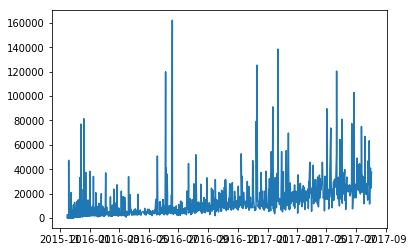

In [199]:
plt.figure(figt)
plt.plot(wrangling_final_df.timestamp, wrangling_final_df.favorite_count)